In [1]:
import torch

This notebook briefly demonstrates the loading and usage of the results (posteriors for global parameters and posterior moments of object-specific parameters).

## Global

The results (posteriors) for the global parameters come in the form of a `MultiSBIPosteriorPlotter` object from Clipppy, which contains (truncated) prior samples (from the validation set) and weights (likelihood-to-evidence = posterior-to-prior ratios) for different groups of parameters of interest:

In [2]:
wgplotter = torch.load('res/cigars-dindep-10000/1/wgplotter.pt', map_location='cpu', weights_only=False)

In [3]:
wgplotter.samples

<xarray.Dataset> Size: 333kB
Dimensions:             (sample: 6400)
Dimensions without coordinates: sample
Data variables: (12/13)
    sigma_res           (sample) float32 26kB 0.09325 0.08978 ... 0.0939 0.1056
    dtd_A               (sample) float32 26kB -12.16 -12.15 ... -12.16 -12.14
    dtd_s               (sample) float32 26kB -1.35 -1.325 ... -1.315 -1.324
    beta                (sample) float32 26kB 2.172 2.292 2.234 ... 2.198 2.179
    alpha               (sample) float32 26kB -0.1407 -0.1434 ... -0.1422
    gamma_M_age         (sample) float32 26kB -0.02311 -0.03663 ... -0.02753
    ...                  ...
    step_M_logmass      (sample) float32 26kB -0.1158 -0.03928 ... -0.1094
    M0                  (sample) float32 26kB -19.52 -19.43 ... -19.51 -19.44
    Om0                 (sample) float32 26kB 0.2636 0.1984 ... 0.2152 0.2896
    Ode0                (sample) float32 26kB 0.7138 0.6176 ... 0.6172 0.7171
    alpha_c             (sample) float32 26kB 0.003322 0.001371 ... 0.0026
    gamma_M_logzsol     (sample) float32 26kB -0.1069 -0.002022 ... -0.1353

In [4]:
wgplotter.weights.keys()

dict_keys([('Om0', 'Ode0'), ('dtd_A', 'dtd_s'), 'M0', 'sigma_res', 'alpha', 'beta', 'alpha_c', 'step_M_logmass_loc', ('step_M_logmass', 'gamma_M_logzsol'), ('step_M_logmass', 'gamma_M_age'), ('gamma_M_logzsol', 'gamma_M_age')])

In [5]:
wgplotter.weights['Om0', 'Ode0']

<xarray.DataArray (sample: 6400)> Size: 26kB
array([2.9844442e-09, 2.7332698e-08, 8.1702301e-06, ..., 2.2281511e-04,
       2.5977371e-05, 3.9488406e-04], shape=(6400,), dtype=float32)
Dimensions without coordinates: sample

These can be used to display a weighted histogram or kernel density estimate and/or contours with one's favourite plotter. The object itself can create a nifty "corner" plot for each "group"

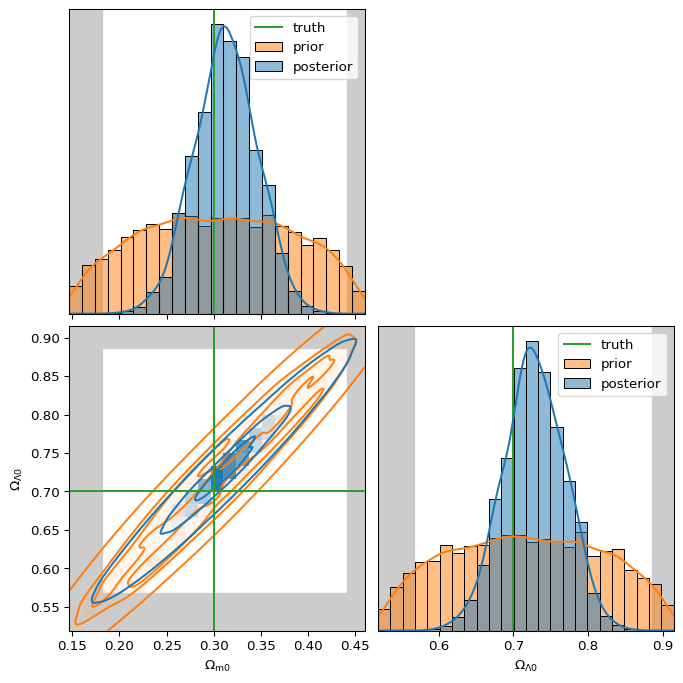

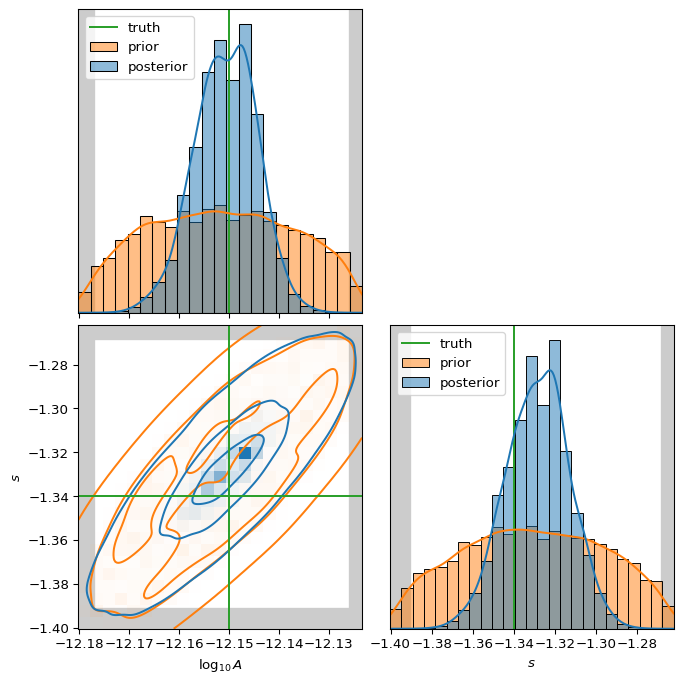

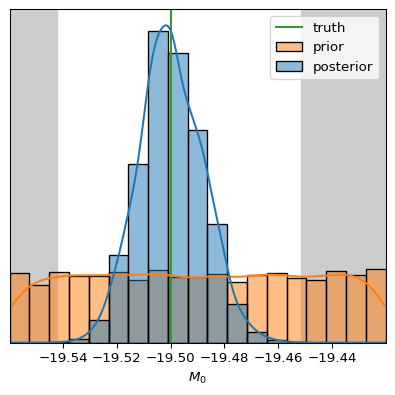

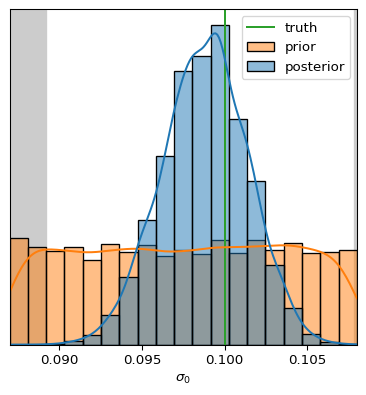

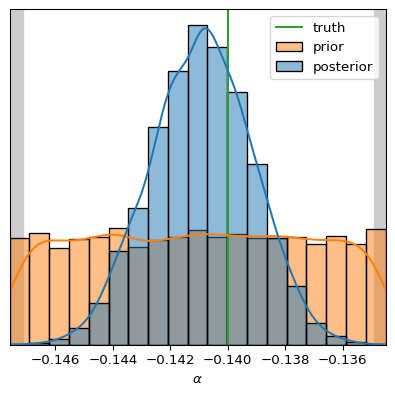

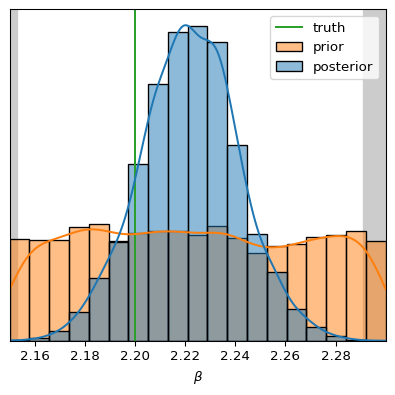

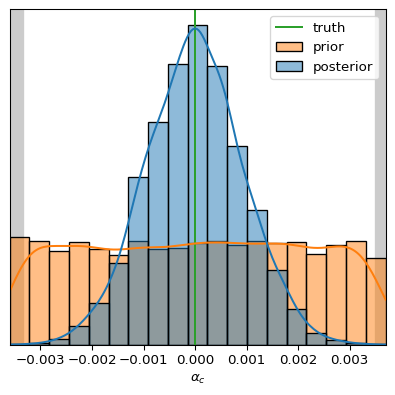

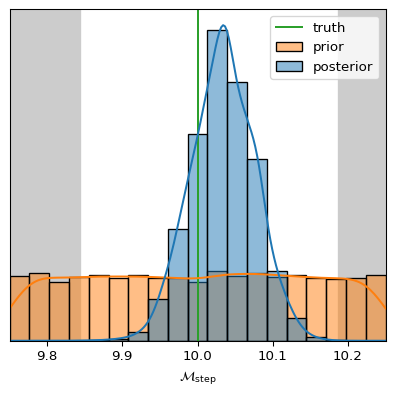

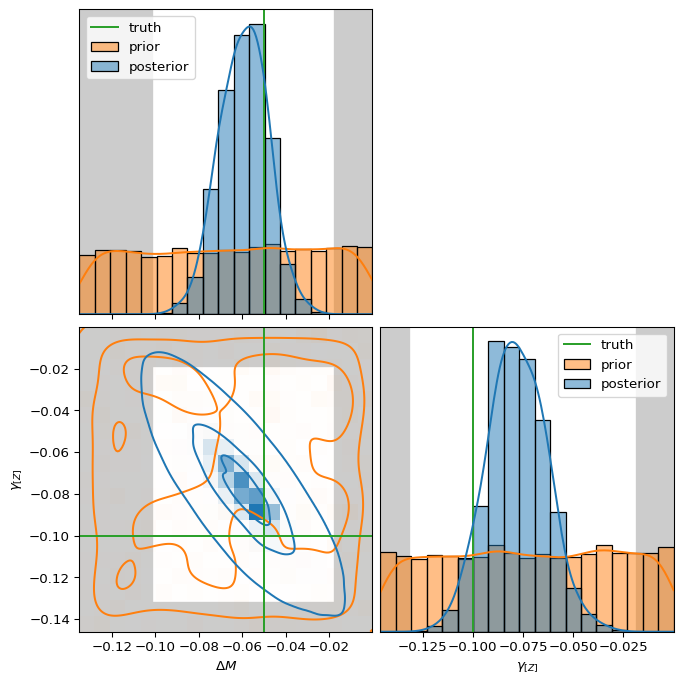

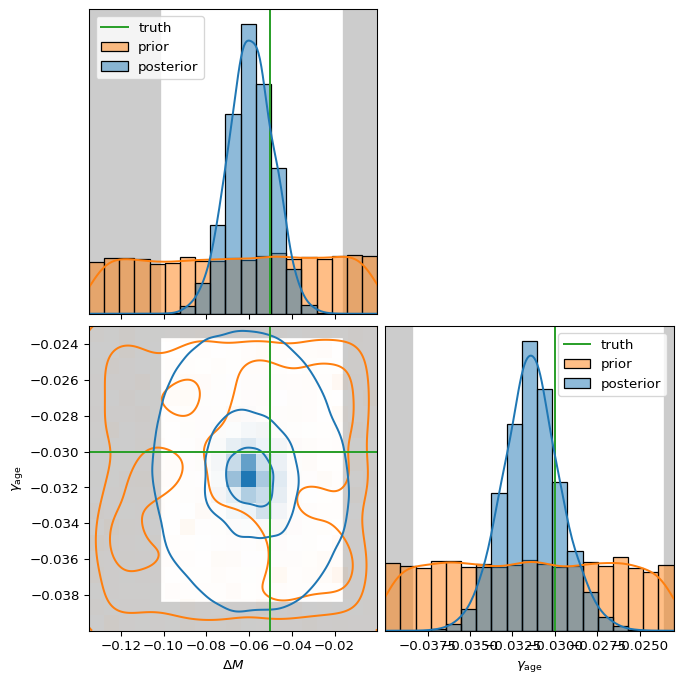

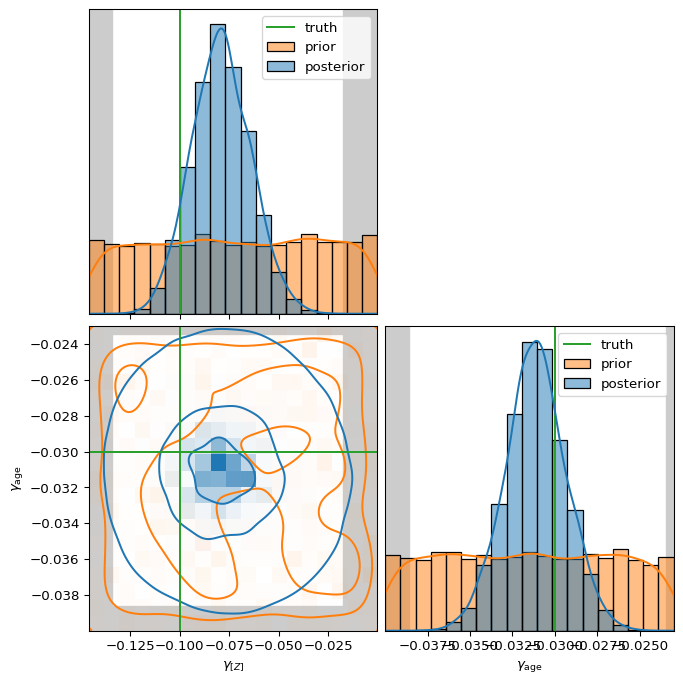

In [6]:
for group in wgplotter.weights.keys():
    wgplotter.corner(group)

The "truths" (coming from the additional information in the mock-data file) are also recorded in the `wgplotter`.

## Object-specific

We release posterior moments for local parameters of all objects in the `COUNTS=1000` data set (with ~1600 objects).

In [7]:
lpoststats = torch.load('res/cigars-dindep-1000/3/lpoststats.pt', map_location='cpu', weights_only=False)

These can be used in conjunction with the "truths" from the data file to plot a "true-vs-inferred" plot:

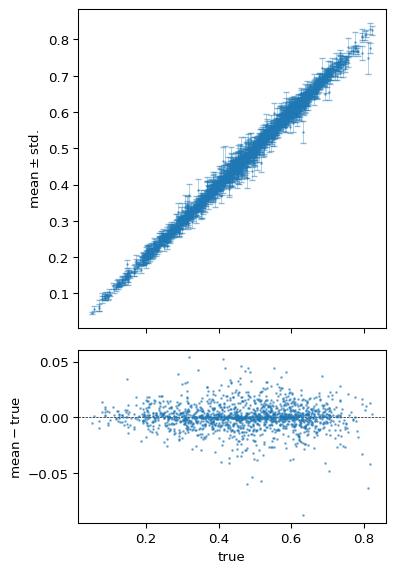

In [8]:
from matplotlib import pyplot as plt

data = torch.load('data/cigars-dindep-1000.pt', map_location='cpu', weights_only=False)

param = 'z'

truth, mean, std = data[param], lpoststats[param]['mean'], lpoststats[param]['std']

fig, axs = plt.subplots(2, 1, sharex='col', figsize=(4, 6), height_ratios=(2, 1))
axs[0].errorbar(truth, mean, std, ls='none', lw=0.5, marker='.', ms='2', alpha=0.5)

axs[1].axhline(0, color='k', ls='--', lw=0.5)
axs[1].plot(truth, mean-truth, '.', ms='2', alpha=0.5)

axs[0].set(ylabel=r'$\mathrm{mean}\pm\mathrm{std.}$', aspect='equal')
axs[1].set(xlabel='true', ylabel=r'$\mathrm{mean}-\mathrm{true}$');